# Import all the required libraries

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow.keras
from pandas_profiling import ProfileReport
import pydicom
import glob
import os
import cv2
from tensorflow.keras import Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras import metrics
from keras.optimizers import Adam 
import keras
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Read the detailed class file

In [114]:
stage1ClassDF = pd.read_csv('./rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
stage1ClassDF.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [115]:
# Get statistical information about detailed class dataset
stage1ClassDF.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,1c44e0a4-4612-438f-9a83-8d5bf919cb67,No Lung Opacity / Not Normal
freq,4,11821


In [116]:
# get the dataset info
stage1ClassDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
patientId    30227 non-null object
class        30227 non-null object
dtypes: object(2)
memory usage: 472.4+ KB


In [117]:
ProfileReport(stage1ClassDF)

In [118]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = stage1ClassDF[stage1ClassDF.duplicated()]

In [119]:
duplicateRowsDF.head()

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity


In [120]:
# Get unique rows
uniqueDF = stage1ClassDF.drop_duplicates()

In [121]:
uniqueDF.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [122]:
print("unique count = {}".format(uniqueDF.count()))

unique count = patientId    26684
class        26684
dtype: int64


In [123]:
# check distribution of data based on class
uniqueDF['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

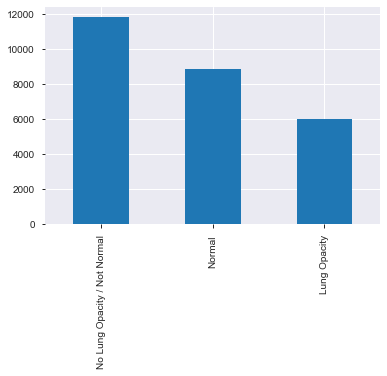

In [124]:
uniqueDF['class'].value_counts().plot.bar()

In [125]:
# Read the test label
stageLabelDF = pd.read_csv('./rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
stageLabelDF.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [126]:
stageLabelDF[stageLabelDF["Target"] == 0]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


In [127]:
stageLabelDF.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [128]:
stageLabelDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [129]:
print("unique count = {}".format(stageLabelDF.count()))

unique count = patientId    30227
x             9555
y             9555
width         9555
height        9555
Target       30227
dtype: int64


In [130]:
ProfileReport(stageLabelDF)

In [131]:
duplicateLabelRowsDF = stageLabelDF[stageLabelDF.duplicated()]
print("duplicate rows count {}".format(duplicateLabelRowsDF.count()))

duplicate rows count patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


In [132]:
# check distribution of data based on class
stageLabelDF['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

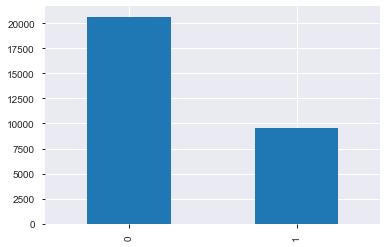

In [133]:
# check the distribution of data
stageLabelDF['Target'].value_counts().plot.bar()

In [137]:
#drop rows with NAN 
stageLabelDF.x.fillna(0, inplace=True)
stageLabelDF.y.fillna(0, inplace=True)
stageLabelDF.width.fillna(1023, inplace=True)
stageLabelDF.height.fillna(1023, inplace=True)

In [138]:
#Merge dataset with Normal person( normal person has having NaN values)
mergedDF = uniqueDF.merge(stageLabelDF, on = 'patientId', how = 'left')
mergedDF.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0.0,0.0,1023.0,1023.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


# Read dicom files

In [139]:
dicom_train_file_path = "./rsna-pneumonia-detection-challenge/stage_2_train_images"
dicom_test_file_path = "./rsna-pneumonia-detection-challenge/stage_2_test_images"

In [140]:
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [141]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [142]:
train_image_fps, train_image_annotations = parse_dataset(dicom_train_file_path, stageLabelDF)

In [143]:
#utility functions
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    fig,ax = plt.subplots(1, figsize=(10,10))
    plt.imshow(im[:, :], cmap='gray')
    plt.axis('on')

In [144]:
def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [145]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [146]:
parsedDict = parse_data(mergedDF)

In [147]:
parsedDict

{'0004cfab-14fd-4e49-80ba-63a80b6bddd6': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
  'label': 0,
  'boxes': []},
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
  'label': 0,
  'boxes': []},
 '00322d4d-1c29-4943-afc9-b6754be640eb': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
  'label': 0,
  'boxes': []},
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
  'label': 0,
  'boxes': []},
 '00436515-870c-4b36-a041-de91049b9ab4': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
  'label': 1,
  'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]},
 '00569f44-917d-4c86-a842-8

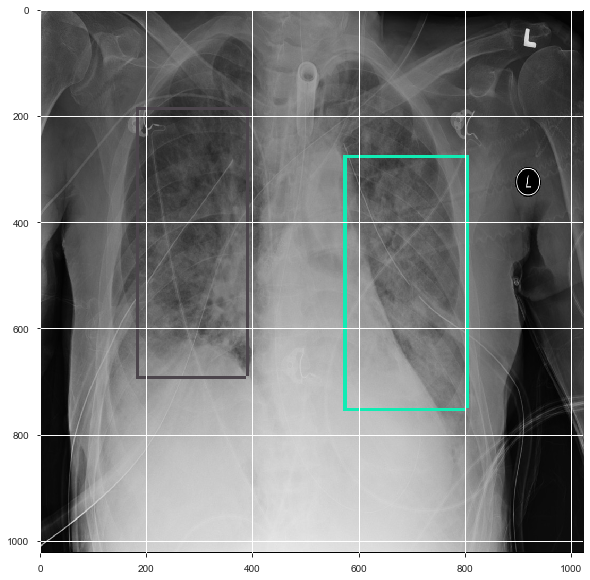

In [148]:
# display image
draw(parsedDict['00f08de1-517e-4652-a04f-d1dc9ee48593'])

In [149]:
# Image for normnal ppl
parsedNormalDict = parse_data(mergedDF[mergedDF['class'] == 'Normal'])

In [150]:
parsedNormalDict

{'003d8fa0-6bf1-40ed-b54c-ac657f8495c5': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
  'label': 0,
  'boxes': []},
 '009482dc-3db5-48d4-8580-5c89c4f01334': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/009482dc-3db5-48d4-8580-5c89c4f01334.dcm',
  'label': 0,
  'boxes': []},
 '009eb222-eabc-4150-8121-d5a6d06b8ebf': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/009eb222-eabc-4150-8121-d5a6d06b8ebf.dcm',
  'label': 0,
  'boxes': []},
 '00a85be6-6eb0-421d-8acf-ff2dc0007e8a': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.dcm',
  'label': 0,
  'boxes': []},
 '00f87de5-5fe0-4921-93ea-914d7e683266': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00f87de5-5fe0-4921-93ea-914d7e683266.dcm',
  'label': 0,
  'boxes': []},
 '01027bc3-dc40-4165-a6c3-d6be2cb7ca34': {'dicom': './rsna-pneumonia-detection-challe

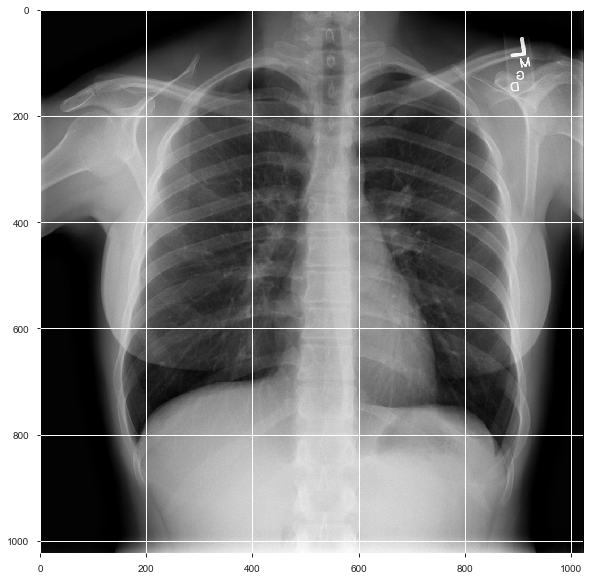

In [151]:
draw(parsedNormalDict['03b10fa5-e7c3-4726-818f-ecbace9da737'])

In [152]:
# Image for not normnal ppl
parsedNotNormalDict = parse_data(mergedDF[mergedDF['class'] == 'No Lung Opacity / Not Normal'])

In [153]:
parsedNotNormalDict

{'0004cfab-14fd-4e49-80ba-63a80b6bddd6': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
  'label': 0,
  'boxes': []},
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
  'label': 0,
  'boxes': []},
 '00322d4d-1c29-4943-afc9-b6754be640eb': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
  'label': 0,
  'boxes': []},
 '00569f44-917d-4c86-a842-81832af98c30': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm',
  'label': 0,
  'boxes': []},
 '006cec2e-6ce2-4549-bffa-eadfcd1e9970': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm',
  'label': 0,
  'boxes': []},
 '008c19e8-a820-403a-930a-bc74a4053664': {'dicom': './rsna-pneumonia-detection-challe

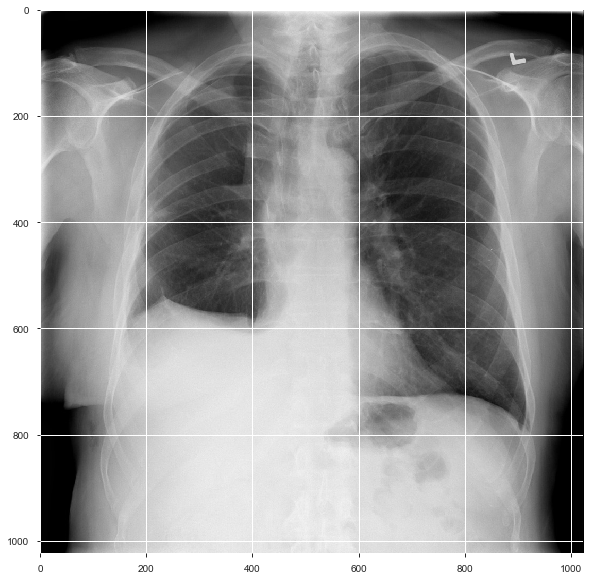

In [154]:
draw(parsedNotNormalDict['006cec2e-6ce2-4549-bffa-eadfcd1e9970'])

In [155]:
# Image for not normnal ppl
parsedLungDict = parse_data(mergedDF[mergedDF['class'] == 'Lung Opacity'])

In [156]:
parsedLungDict

{'00436515-870c-4b36-a041-de91049b9ab4': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
  'label': 1,
  'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]},
 '00704310-78a8-4b38-8475-49f4573b2dbb': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
  'label': 1,
  'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]]},
 '00aecb01-a116-45a2-956c-08d2fa55433f': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00aecb01-a116-45a2-956c-08d2fa55433f.dcm',
  'label': 1,
  'boxes': [[322.0, 288.0, 135.0, 94.0], [299.0, 547.0, 165.0, 119.0]]},
 '00c0b293-48e7-4e16-ac76-9269ba535a62': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00c0b293-48e7-4e16-ac76-9269ba535a62.dcm',
  'label': 1,
  'boxes': [[544.0, 306.0, 244.0, 168.0], [511.0, 650.0, 284.0, 206.0]]},
 '00f08de1-517e-4652-a04f-d1dc9ee4859

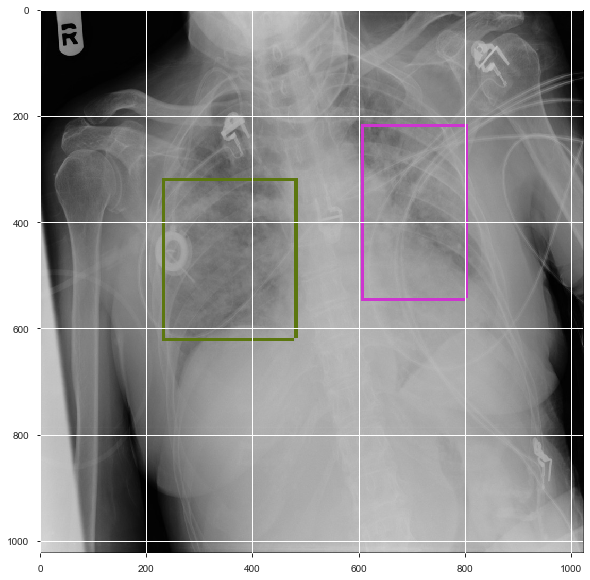

In [157]:
draw(parsedLungDict['019d950b-dd38-4cf3-a686-527a75728be6'])

# Read dicom file

In [158]:
dicomImageData = pydicom.read_file(train_image_fps[0])
dicomImageData

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10658.1517874353.319795
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'ffe9ab5c-9d39-4235-9ade-d725dcad6b76'
(0010, 0020) Patient ID                          LO: 'ffe9ab5c-9d39-4235-9ade-d725dcad6b76'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [159]:
# check fields
imagefields = dicomImageData.dir()
imagefields

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

# Convert image data to dataframe

In [160]:
imageMetaData = np.array([[dicomImageData.AccessionNumber,
dicomImageData.BitsAllocated,
dicomImageData.BitsStored,
dicomImageData.BodyPartExamined,
dicomImageData.Columns,
dicomImageData.ConversionType,
dicomImageData.HighBit,
dicomImageData.InstanceNumber,
dicomImageData.LossyImageCompression,
dicomImageData.LossyImageCompressionMethod,
dicomImageData.Modality,
dicomImageData.PatientAge,
dicomImageData.PatientBirthDate,
dicomImageData.PatientID,
dicomImageData.PatientName,
dicomImageData.PatientOrientation,
dicomImageData.PatientSex,
dicomImageData.PhotometricInterpretation,
dicomImageData.PixelData,
dicomImageData.PixelRepresentation,
dicomImageData.PixelSpacing,
dicomImageData.ReferringPhysicianName,
dicomImageData.Rows,
dicomImageData.SOPClassUID,
dicomImageData.SOPInstanceUID,
dicomImageData.SamplesPerPixel,
dicomImageData.SeriesDescription,
dicomImageData.SeriesInstanceUID,
dicomImageData.SeriesNumber,
dicomImageData.SpecificCharacterSet,
dicomImageData.StudyDate,
dicomImageData.StudyID,
dicomImageData.StudyInstanceUID,
dicomImageData.StudyTime,
dicomImageData.ViewPosition]])

In [161]:
imageMetaData.shape

(1, 35)

In [162]:
for image in train_image_fps[1:]:
    d = pydicom.read_file(image)
    image_meta = np.array([[d.AccessionNumber,
                        d.BitsAllocated,
                        d.BitsStored,
                        d.BodyPartExamined,
                        d.Columns,
                        d.ConversionType,
                        d.HighBit,
                        d.InstanceNumber,
                        d.LossyImageCompression,
                        d.LossyImageCompressionMethod,
                        d.Modality,
                        d.PatientAge,
                        d.PatientBirthDate,
                        d.PatientID,
                        d.PatientName,
                        d.PatientOrientation,
                        d.PatientSex,
                        d.PhotometricInterpretation,
                        d.PixelData,
                        d.PixelRepresentation,
                        d.PixelSpacing,
                        d.ReferringPhysicianName,
                        d.Rows,
                        d.SOPClassUID,
                        d.SOPInstanceUID,
                        d.SamplesPerPixel,
                        d.SeriesDescription,
                        d.SeriesInstanceUID,
                        d.SeriesNumber,
                        d.SpecificCharacterSet,
                        d.StudyDate,
                        d.StudyID,
                        d.StudyInstanceUID,
                        d.StudyTime,
                        d.ViewPosition]])
    imageMetaData = np.append(imageMetaData, image_meta, axis = 0)

train_data = pd.DataFrame(imageMetaData, columns = imagefields)

In [163]:
train_data.head()

,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.10658.15178743...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.10658.15178743...,000000.00,PA
1,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.24492.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.24492.15178744...,000000.00,AP
2,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.19945.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.19945.15178744...,000000.00,AP
3,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.16500.15178743...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.16500.15178743...,000000.00,PA
4,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.28981.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28981.15178744...,000000.00,PA


In [164]:
train_data.columns

Index(['AccessionNumber', 'BitsAllocated', 'BitsStored', 'BodyPartExamined',
       'Columns', 'ConversionType', 'HighBit', 'InstanceNumber',
       'LossyImageCompression', 'LossyImageCompressionMethod', 'Modality',
       'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientName',
       'PatientOrientation', 'PatientSex', 'PhotometricInterpretation',
       'PixelData', 'PixelRepresentation', 'PixelSpacing',
       'ReferringPhysicianName', 'Rows', 'SOPClassUID', 'SOPInstanceUID',
       'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID',
       'SeriesNumber', 'SpecificCharacterSet', 'StudyDate', 'StudyID',
       'StudyInstanceUID', 'StudyTime', 'ViewPosition'],
      dtype='object')

In [165]:
# repeat the process for test data
test_image_fps = get_dicom_fps(dicom_test_file_path)

In [166]:
dicomImageTestData = pydicom.read_file(train_image_fps[0])

imageTestMetaData = np.array([[dicomImageTestData.AccessionNumber,
dicomImageTestData.BitsAllocated,
dicomImageTestData.BitsStored,
dicomImageTestData.BodyPartExamined,
dicomImageTestData.Columns,
dicomImageTestData.ConversionType,
dicomImageTestData.HighBit,
dicomImageTestData.InstanceNumber,
dicomImageTestData.LossyImageCompression,
dicomImageTestData.LossyImageCompressionMethod,
dicomImageTestData.Modality,
dicomImageTestData.PatientAge,
dicomImageTestData.PatientBirthDate,
dicomImageTestData.PatientID,
dicomImageTestData.PatientName,
dicomImageTestData.PatientOrientation,
dicomImageTestData.PatientSex,
dicomImageTestData.PhotometricInterpretation,
dicomImageTestData.PixelData,
dicomImageTestData.PixelRepresentation,
dicomImageTestData.PixelSpacing,
dicomImageTestData.ReferringPhysicianName,
dicomImageTestData.Rows,
dicomImageTestData.SOPClassUID,
dicomImageTestData.SOPInstanceUID,
dicomImageTestData.SamplesPerPixel,
dicomImageTestData.SeriesDescription,
dicomImageTestData.SeriesInstanceUID,
dicomImageTestData.SeriesNumber,
dicomImageTestData.SpecificCharacterSet,
dicomImageTestData.StudyDate,
dicomImageTestData.StudyID,
dicomImageTestData.StudyInstanceUID,
dicomImageTestData.StudyTime,
dicomImageTestData.ViewPosition]])

In [167]:
for image in train_image_fps[1:]:
    d = pydicom.read_file(image)
    image_meta = np.array([[d.AccessionNumber,
                        d.BitsAllocated,
                        d.BitsStored,
                        d.BodyPartExamined,
                        d.Columns,
                        d.ConversionType,
                        d.HighBit,
                        d.InstanceNumber,
                        d.LossyImageCompression,
                        d.LossyImageCompressionMethod,
                        d.Modality,
                        d.PatientAge,
                        d.PatientBirthDate,
                        d.PatientID,
                        d.PatientName,
                        d.PatientOrientation,
                        d.PatientSex,
                        d.PhotometricInterpretation,
                        d.PixelData,
                        d.PixelRepresentation,
                        d.PixelSpacing,
                        d.ReferringPhysicianName,
                        d.Rows,
                        d.SOPClassUID,
                        d.SOPInstanceUID,
                        d.SamplesPerPixel,
                        d.SeriesDescription,
                        d.SeriesInstanceUID,
                        d.SeriesNumber,
                        d.SpecificCharacterSet,
                        d.StudyDate,
                        d.StudyID,
                        d.StudyInstanceUID,
                        d.StudyTime,
                        d.ViewPosition]])
    imageTestMetaData = np.append(imageTestMetaData, image_meta, axis = 0)

test_data = pd.DataFrame(imageTestMetaData, columns = imagefields)

In [168]:
test_data.head()

,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.10658.15178743...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.10658.15178743...,000000.00,PA
1,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.24492.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.24492.15178744...,000000.00,AP
2,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: AP,1.2.276.0.7230010.3.1.3.8323329.19945.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.19945.15178744...,000000.00,AP
3,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.16500.15178743...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.16500.15178743...,000000.00,PA
4,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,1,view: PA,1.2.276.0.7230010.3.1.3.8323329.28981.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28981.15178744...,000000.00,PA


In [169]:
train_stats = train_data.describe(include = "all").transpose()

In [170]:
test = test_data.rename(columns = {'PatientID':'patientId'})
train = train_data.rename(columns = {'PatientID':'patientId'})

In [171]:
# number of missing records
train_stats['missing'] = 1 - train_stats['count']/len(train_data)

In [172]:
train_stats

,count,unique,top,freq,missing
AccessionNumber,26684,1,,26684,0
BitsAllocated,26684,1,8,26684,0
BitsStored,26684,1,8,26684,0
BodyPartExamined,26684,1,CHEST,26684,0
Columns,26684,1,1024,26684,0
ConversionType,26684,1,WSD,26684,0
HighBit,26684,1,7,26684,0
InstanceNumber,26684,1,1,26684,0
LossyImageCompression,26684,1,01,26684,0
LossyImageCompressionMethod,26684,1,ISO_10918_1,26684,0


In [173]:
# drop unwanted columns
columnsNotRequired = ['BitsAllocated', 'BitsStored', 'Columns', 'HighBit',
                'InstanceNumber', 'LossyImageCompression', 'PixelRepresentation',
                'Rows', 'SamplesPerPixel', 'SeriesNumber', 'StudyDate', 
                'AccessionNumber', 'PatientBirthDate', 'PatientOrientation',
                'ReferringPhysicianName', 'StudyID', 'StudyTime', 'BodyPartExamined',
                'ConversionType', 'LossyImageCompressionMethod', 'Modality', 'PhotometricInterpretation',
                'SOPClassUID', 'SpecificCharacterSet', 'PatientName', 'SOPInstanceUID',
                'SeriesInstanceUID', 'StudyInstanceUID', 'SeriesDescription']

train = train.drop(columnsNotRequired, axis = 1)

In [174]:
test = test.drop(columnsNotRequired, axis = 1)

In [175]:
train.head()

,PatientAge,patientId,PatientSex,PixelData,PixelSpacing,ViewPosition
0,45,ffe9ab5c-9d39-4235-9ade-d725dcad6b76,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.171, 0.171]",PA
1,57,6994ebc6-50b9-4026-9759-9a93414e2cf1,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP
2,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP
3,20,b77ab1ed-342b-452f-83b3-3ab219c36840,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.19431099999999998, 0.19431099999999998]",PA
4,38,8957ebd9-d891-412f-8bd7-7ecb149c4967,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.14300000000000002, 0.14300000000000002]",PA


In [176]:
# merge data with patient information
finalPatientTrainInfo = train.merge(mergedDF, on = 'patientId', how = 'inner')
finalPatientTestInfo = test.merge(mergedDF, on = 'patientId', how = 'inner')

In [177]:
finalPatientTrainInfo.head()

,PatientAge,patientId,PatientSex,PixelData,PixelSpacing,ViewPosition,class,x,y,width,height,Target
0,45,ffe9ab5c-9d39-4235-9ade-d725dcad6b76,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.171, 0.171]",PA,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
1,57,6994ebc6-50b9-4026-9759-9a93414e2cf1,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
2,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,511.0,248.0,303.0,388.0,1
3,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,77.0,266.0,282.0,279.0,1
4,20,b77ab1ed-342b-452f-83b3-3ab219c36840,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.19431099999999998, 0.19431099999999998]",PA,Normal,0.0,0.0,1023.0,1023.0,0


In [178]:
finalPatientTestInfo.head()

,PatientAge,patientId,PatientSex,PixelData,PixelSpacing,ViewPosition,class,x,y,width,height,Target
0,45,ffe9ab5c-9d39-4235-9ade-d725dcad6b76,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.171, 0.171]",PA,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
1,57,6994ebc6-50b9-4026-9759-9a93414e2cf1,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0
2,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,511.0,248.0,303.0,388.0,1
3,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,77.0,266.0,282.0,279.0,1
4,20,b77ab1ed-342b-452f-83b3-3ab219c36840,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.19431099999999998, 0.19431099999999998]",PA,Normal,0.0,0.0,1023.0,1023.0,0


In [179]:
#check unique class
finalPatientTrainInfo['class'].unique()

array(['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal'],
      dtype=object)

In [180]:
#check unique class
finalPatientTestInfo['class'].unique()

array(['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal'],
      dtype=object)

In [181]:
#create age bucket
finalPatientTrainInfo['age_by_decade'] = pd.cut(x=pd.to_numeric(finalPatientTrainInfo['PatientAge']), bins=[19, 29, 39, 49,59,69,79,89,99], labels=['0-20', '20-30', '30-40','40-50','50-60','60-70','70-80','80-90'])


In [182]:
finalPatientTrainInfo.head()

,PatientAge,patientId,PatientSex,PixelData,PixelSpacing,ViewPosition,class,x,y,width,height,Target,age_by_decade
0,45,ffe9ab5c-9d39-4235-9ade-d725dcad6b76,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.171, 0.171]",PA,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0,30-40
1,57,6994ebc6-50b9-4026-9759-9a93414e2cf1,F,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,No Lung Opacity / Not Normal,0.0,0.0,1023.0,1023.0,0,40-50
2,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,511.0,248.0,303.0,388.0,1,50-60
3,61,af467edc-df3a-4c0e-ade8-0249d40607e9,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.139, 0.139]",AP,Lung Opacity,77.0,266.0,282.0,279.0,1,50-60
4,20,b77ab1ed-342b-452f-83b3-3ab219c36840,M,b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00...,"[0.19431099999999998, 0.19431099999999998]",PA,Normal,0.0,0.0,1023.0,1023.0,0,0-20


In [183]:
#get data based on age group
finalPatientTrainInfo.groupby("age_by_decade").count().head()

,PatientAge,patientId,PatientSex,PixelData,PixelSpacing,ViewPosition,class,x,y,width,height,Target
age_by_decade,,,,,,,,,,,,
0-20,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542
20-30,4341,4341,4341,4341,4341,4341,4341,4341,4341,4341,4341,4341
30-40,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732,5732
40-50,7416,7416,7416,7416,7416,7416,7416,7416,7416,7416,7416,7416
50-60,5075,5075,5075,5075,5075,5075,5075,5075,5075,5075,5075,5075


In [184]:
train_image_fps

['./rsna-pneumonia-detection-challenge/stage_2_train_images/ffe9ab5c-9d39-4235-9ade-d725dcad6b76.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/6994ebc6-50b9-4026-9759-9a93414e2cf1.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/af467edc-df3a-4c0e-ade8-0249d40607e9.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/b77ab1ed-342b-452f-83b3-3ab219c36840.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/8957ebd9-d891-412f-8bd7-7ecb149c4967.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/413d1f9a-dbd3-476c-b71f-ffd23ef38b98.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/ded57620-eb2d-403c-a908-f5499ba188d3.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/68dbe4c9-2671-4c71-8a42-ab6dc868105f.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/c9713628-3809-4e51-b6f5-0dd13a5f1ab4.dcm',
 './rsna-pneumonia-detection-challenge/stage_2_train_images/d112ae38-3ba8

In [185]:

parsedDict['00f08de1-517e-4652-a04f-d1dc9ee48593']

{'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00f08de1-517e-4652-a04f-d1dc9ee48593.dcm',
 'label': 1,
 'boxes': [[184.0, 181.0, 506.0, 206.0], [275.0, 571.0, 476.0, 230.0]]}

In [196]:
def get_image_label(image):
    patientID = image.split(".")[0]
    label = parsedDict[patientID].get("label")
    if label == 1:
        return "Pneumonia"
    else:
        return "Normal"

In [197]:
# method to convert dicom files to jpeg
def convertTrainDicomToJPG(imagePath,targetPath):
    path = os.listdir(imagePath)
    for idx,image in enumerate(path):
        if image.endswith(".dcm"):
            img = pydicom.dcmread(os.path.join(imagePath,image))
            rows=[]
            label = get_image_label(image)
            jpgPath = targetPath+"/"+label
            if not os.path.exists(jpgPath):
                os.mkdir(jpgPath) 
            img_pixel = img.pixel_array
            image = image.replace('.dcm','.jpg')
            cv2.imwrite(os.path.join(jpgPath,image),img_pixel)

In [201]:
# method to convert dicom files to jpeg
def convertTestDicomToJPG(imagePath,targetPath):
    if not os.path.exists(targetPath):
        os.mkdir(targetPath) 
    path = os.listdir(imagePath)
    jpgPath = targetPath
    for idx,image in enumerate(path):
        if image.endswith(".dcm"):
            img = pydicom.dcmread(os.path.join(imagePath,image))
            rows=[]
            img_pixel = img.pixel_array
            image = image.replace('.dcm','.jpg')
            cv2.imwrite(os.path.join(jpgPath,image),img_pixel)

In [198]:
#convert train dcm images to jpg
targetPath = "./input"
convertTrainDicomToJPG(dicom_train_file_path,targetPath)

In [202]:
#convert test dcm images to jpg
targetPath = "./test/jpg"
convertTestDicomToJPG(dicom_test_file_path,targetPath)

In [203]:
def create_model():
    model = Sequential()

        # Convolution
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

    #Pooling
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # 2nd Convolution
    model.add(Conv2D(32, (3, 3), activation="relu"))

    # 2nd Pooling layer
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Flatten the layer
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(activation = 'relu', units = 128))
    model.add(Dense(activation = 'sigmoid', units = 1))
    print(model.summary())
    return cnn

In [204]:
# Compile the Neural network
cnn = create_model()
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

In [205]:
# setting the callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

model_file = "model_{epoch:02d}_loss{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]


In [107]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [206]:
train_dir = "./input" # Path to train directory
test_dir = "./test" # Path to test directory

print(train_dir)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64,64),
                                                  batch_size=16,
                                                  class_mode='binary')

./input
Found 24016 images belonging to 2 classes.
Found 2668 images belonging to 2 classes.
Found 3000 images belonging to 1 classes.


In [207]:
cnn_model = cnn.fit_generator(train_generator,
                         steps_per_epoch = 100,
                         epochs = 5,
                         validation_data = validation_generator,
                         validation_steps = 100 ,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 32s 323ms/step - loss: 0.8091 - accuracy: 0.7406 - val_loss: 0.5529 - val_accuracy: 0.7713
Epoch 2/5
100/100 [==============================] - 29s 294ms/step - loss: 0.5073 - accuracy: 0.7875 - val_loss: 0.4592 - val_accuracy: 0.7863
Epoch 3/5
100/100 [==============================] - 28s 281ms/step - loss: 0.5010 - accuracy: 0.7794 - val_loss: 0.6206 - val_accuracy: 0.7738
Epoch 4/5
100/100 [==============================] - 28s 285ms/step - loss: 0.4859 - accuracy: 0.7588 - val_loss: 0.4427 - val_accuracy: 0.7751
Epoch 5/5
100/100 [==============================] - 28s 280ms/step - loss: 0.4770 - accuracy: 0.7644 - val_loss: 0.5772 - val_accuracy: 0.7700


In [208]:
cnn_model.history

{'val_loss': [0.5528839230537415,
  0.45919471979141235,
  0.6206111907958984,
  0.44265204668045044,
  0.5772073268890381],
 'val_accuracy': [0.7712500095367432,
  0.7863408327102661,
  0.7737500071525574,
  0.7750626802444458,
  0.7699999809265137],
 'loss': [0.8090729666411244,
  0.5073156224191189,
  0.5010471197962761,
  0.4858967912197113,
  0.47699402987957],
 'accuracy': [0.740625, 0.7875, 0.779375, 0.75875, 0.764375],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

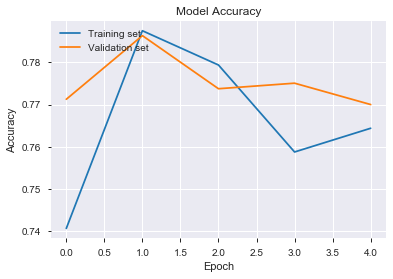

In [209]:
# Accuracy 
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

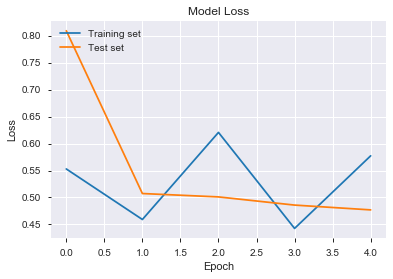

In [210]:
# Loss 

plt.plot(cnn_model.history['val_loss'])
plt.plot(cnn_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [222]:
def display_image(img):
    plt.imshow(img)
    plt.show()

In [225]:
def predict(imageArr):
    score = cnn.predict(imageArr)
    print('Predicted score for given image: ',score, 'No Lung Opacity/Not normal/Pnemonia' if score < 0.5 else 'With Lung Opacity')

In [226]:
print("results")
result  = cnn.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
167/167 [==============================] - 27s 161ms/step
Loss     : 0.91  
Accuracy : 77.47%


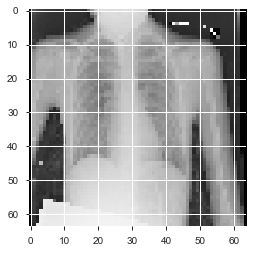

Predicted score for given image:  [[0.34560543]] No Lung Opacity/Not normal/Pnemonia


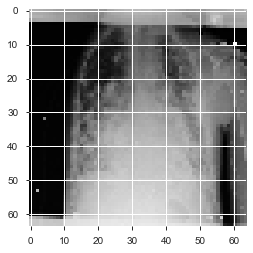

Predicted score for given image:  [[0.23811406]] No Lung Opacity/Not normal/Pnemonia


In [227]:
#load, resize and display test images
TEST_DIR = "./test/jpg/"
test_img1 = os.path.join(TEST_DIR, '2865b97c-a54d-4029-89e6-e25725770eb4.jpg')
test_img2 = os.path.join(TEST_DIR, '29661bc0-02d5-47c0-bbd6-61ea4fae75d7.jpg') #   #0000a175-0e68-4ca4-b1af-167204a7e0bc.png
firstImage = load_img(test_img1, target_size=(64, 64))
secondImage = load_img(test_img2, target_size=(64, 64))

# display images
display_image(firstImage)

#convert image to numpy array, so that Keras can render a prediction
first_image_arr = img_to_array(firstImage)

#expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch_size, height, width, channels)
x = np.expand_dims(first_image_arr, axis=0) * 1./255

#get prediction on test image
predict(x)


# repeat the same for 2nd image

# display images
display_image(secondImage)

#convert image to numpy array, so that Keras can render a prediction
second_image_arr = img_to_array(secondImage)

#expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch_size, height, width, channels)
x = np.expand_dims(second_image_arr, axis=0) * 1./255

#get prediction on test image
predict(x)
